In [2]:
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from tensorflow import keras

In [70]:
# Загружаем данные
file_path = r"D:\DEEP LEARNING\psih_dataset_csv.csv"
df = pd.read_csv(file_path,  sep=';', encoding='cp1251' ).drop_duplicates(subset='text') 
# сразу убрал дубликаты в тексте (их было 115 штук)

print('Dataset size', df.shape)

num_rows, num_features = df.shape

print('row number: ', num_rows)
print('feature number: ', num_features)
print('names of features: ', list(df))

Dataset size (1833, 2)
row number:  1833
feature number:  2
names of features:  ['text', 'label']


In [15]:
df.head()

,text,label
0,"Два года, начиная с 16, жила в странном состоя...",депрессия
1,Прошу реального совета. Как вы вышли с депресс...,депрессия
2,Мне кажется у меня депрессия! Уже никак не отх...,депрессия
3,"Очень прошу помощи. Скажите, было ли у кого-то...",депрессия
4,Здравствуйте! Мне 19 лет. Где-то с 13 лет муча...,депрессия


In [71]:
# Пошафлил данные, а то они, кажется, шли по порядку
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)
df.head()

,text,label
0,Стоит ли рожать детей с биполярным аффективным...,биполярное аффективное расстройство
1,"Встречаюсь с мужчиной год, зовет замуж. К вели...",шизофрения
2,"Расстались ,скоро пол года минует я все не мог...",депрессия
3,Как выходите с депрессивной фазы? #биполярноер...,биполярное аффективное расстройство
4,"Подруга оч странно себя ведёт, но это в период...",шизофрения


биполярное аффективное расстройство      114
депрессия                                576
обсессивно-компульсивное расстройство    190
расстройство пищевого поведения          359
шизофрения                               594
Name: label, dtype: int64


<AxesSubplot:>

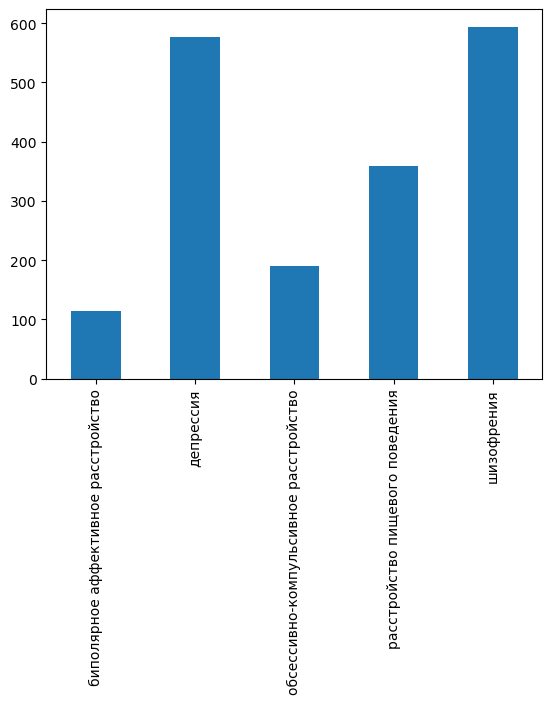

In [17]:
# Для наглядности посмотрим на количество лейблов
import matplotlib.pyplot as plt
%matplotlib inline
vc = df['label'].value_counts()
vc = vc.sort_index()
print(vc)
vc.plot(kind='bar')

## Попробуем сначала нейронку на GRU

In [72]:
# делаем токенизацию
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(df['text'])

encoded_docs = t.texts_to_matrix(df['text'], mode='tfidf')
print(encoded_docs.shape)
encoded_docs

(1833, 26288)


array([[0.        , 1.85174347, 1.68327985, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.80209187, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.6285047 , 2.09300893, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 2.2860004 , 1.91402731, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.85174347, 1.91402731, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.6285047 , 2.23924757, ..., 6.82165258, 6.82165258,
        6.82165258]])

In [73]:
y_dummy = pd.get_dummies(df['label'])

index_to_label = {index: label for index, label in enumerate(y_dummy.columns)}
index_to_label

{0: 'биполярное аффективное расстройство',
 1: 'депрессия',
 2: 'обсессивно-компульсивное расстройство',
 3: 'расстройство пищевого поведения',
 4: 'шизофрения'}

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_docs, y_dummy, test_size=0.2)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('------------------------------')
print('y_train: ' , y_train.shape)
print('y_test: ' , y_test.shape)

X_train:  (1466, 26288)
X_test:  (367, 26288)
------------------------------
y_train:  (1466, 5)
y_test:  (367, 5)


In [21]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, Reshape, Dropout, LSTM, GRU, BatchNormalization, Bidirectional
from keras import layers
from keras import models
from keras.regularizers import l2

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(26288,)))
model.add(Reshape((1, 64)))

# GRU Layers
model.add(GRU(units=64, return_sequences=True))

# Bidirectional GRU Layers
model.add(Bidirectional(GRU(units=64, return_sequences=True)))
model.add(Bidirectional(GRU(units=64)))  

model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(5, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1682496   
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 gru (GRU)                   (None, 1, 64)             24960     
                                                                 
 bidirectional (Bidirection  (None, 1, 128)            49920     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 batch_normalization (Batch  (None, 128)               

In [22]:
from keras import backend as K
from keras.callbacks import EarlyStopping, LambdaCallback


def f1_score(y_true, y_pred):
    # Вычисление метрик precision и recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Вычисление F1-score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

f1_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"val_f1_score: {logs['val_f1_score']}"))

# Компиляция модели с использованием кастомной метрики f1_score
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

es = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [34]:
model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks = f1_callback)

Epoch 1/100
6/6 [==============================] - 0s 53ms/step - loss: 0.0047 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.7295 - val_accuracy: 0.7820 - val_f1_score: 0.7875
Epoch 2/100
6/6 [==============================] - 0s 36ms/step - loss: 0.0046 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.7367 - val_accuracy: 0.7766 - val_f1_score: 0.7875
Epoch 3/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0046 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.7415 - val_accuracy: 0.7766 - val_f1_score: 0.7849
Epoch 4/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0045 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.7425 - val_accuracy: 0.7766 - val_f1_score: 0.7849
Epoch 5/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0045 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.7411 - val_accuracy: 0.7766 - val_f1_score: 0.7849
Epoch 6/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0045 - accuracy:

In [35]:
# Предсказание
predictions = model.predict(X_test)
print(predictions.shape)
print(predictions)

12/12 [==============================] - 0s 5ms/step
(367, 5)
[[7.5553218e-04 9.9663651e-01 1.1019609e-03 7.2065752e-04 7.8528305e-04]
 [1.1094214e-04 1.6316291e-04 1.9366338e-04 1.3775459e-04 9.9939442e-01]
 [2.9366161e-03 9.8148704e-01 7.6013058e-03 4.4405214e-03 3.5345308e-03]
 ...
 [2.5586195e-02 1.1439991e-01 6.6977972e-01 3.2262474e-02 1.5797167e-01]
 [5.0945749e-04 9.1383222e-04 9.9678195e-01 7.3146611e-04 1.0632648e-03]
 [4.8812816e-04 1.0142291e-03 9.9686664e-01 6.9551799e-04 9.3549781e-04]]


In [36]:
y_preds = np.argmax(predictions, axis=1).tolist()

y_labels = [index_to_label[index] for index in y_preds]

In [37]:
yy = y_test.idxmax(axis=1)

In [38]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.classification_report(yy, y_labels))

                                       precision    recall  f1-score   support

  биполярное аффективное расстройство       0.47      0.32      0.38        22
                            депрессия       0.82      0.84      0.83       121
обсессивно-компульсивное расстройство       0.60      0.64      0.62        33
      расстройство пищевого поведения       0.90      0.81      0.85        77
                           шизофрения       0.74      0.81      0.77       114

                             accuracy                           0.77       367
                            macro avg       0.71      0.68      0.69       367
                         weighted avg       0.77      0.77      0.77       367



Бенчмарк:

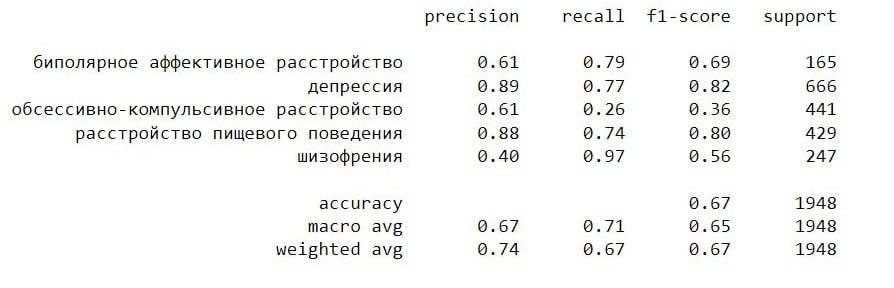

### В общем и целом итог такой - accuracy ~0.8 на этой модели, f1score по всем классам более менее хороши, кроме биполярки

### Попробуем перебалансировать классы, чтобы избавиться от недопредставленности некоторых классов

In [28]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(df['label'])

# Уникальные метки классов
unique_classes = np.unique(y_train_encoded)

# Веса классов
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_encoded)

# Словарь для хранения меток классов и их весов
class_weight_dict = dict(zip(unique_classes, class_weights))
class_weight_dict

{0: 3.2157894736842105,
 1: 0.6364583333333333,
 2: 1.9294736842105262,
 3: 1.0211699164345405,
 4: 0.6171717171717171}

In [29]:
model.fit(X_train, y_train, epochs=100, batch_size=256, 
          validation_data=(X_test, y_test), 
          callbacks = f1_callback,
          class_weight=class_weight_dict)

Epoch 1/100
6/6 [==============================] - 5s 51ms/step - loss: 0.0139 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.6663 - val_accuracy: 0.7793 - val_f1_score: 0.7885
Epoch 2/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0134 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.6714 - val_accuracy: 0.7875 - val_f1_score: 0.7889
Epoch 3/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0132 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.6755 - val_accuracy: 0.7875 - val_f1_score: 0.7870
Epoch 4/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0129 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.6772 - val_accuracy: 0.7820 - val_f1_score: 0.7862
Epoch 5/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0126 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.6758 - val_accuracy: 0.7847 - val_f1_score: 0.7876
Epoch 6/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0124 - accuracy:

In [30]:
# Предсказание
predictions = model.predict(X_test)
print(predictions.shape)
print(predictions)

12/12 [==============================] - 0s 5ms/step
(367, 5)
[[2.4215421e-03 9.9034131e-01 2.5934833e-03 2.0760768e-03 2.5676049e-03]
 [2.3492781e-04 3.8601659e-04 3.5002673e-04 2.8772786e-04 9.9874133e-01]
 [5.7755434e-03 9.6763623e-01 1.3050524e-02 6.5539163e-03 6.9837305e-03]
 ...
 [2.3555461e-02 8.2391962e-02 7.8291684e-01 2.3538081e-02 8.7597646e-02]
 [3.5885689e-04 4.6766992e-04 9.9807370e-01 5.1956705e-04 5.8011332e-04]
 [4.1959280e-04 5.4219761e-04 9.9790156e-01 5.4095441e-04 5.9567956e-04]]


In [31]:
y_preds = np.argmax(predictions, axis=1).tolist()

y_labels = [index_to_label[index] for index in y_preds]

In [32]:
yy = y_test.idxmax(axis=1)

In [33]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.classification_report(yy, y_labels))

                                       precision    recall  f1-score   support

  биполярное аффективное расстройство       0.50      0.41      0.45        22
                            депрессия       0.83      0.83      0.83       121
обсессивно-компульсивное расстройство       0.59      0.67      0.63        33
      расстройство пищевого поведения       0.91      0.82      0.86        77
                           шизофрения       0.76      0.82      0.79       114

                             accuracy                           0.78       367
                            macro avg       0.72      0.71      0.71       367
                         weighted avg       0.78      0.78      0.78       367



### Видно, что ребаланс классов ничем не помог, но и не ухудшил ситуацию

### А что будет, если не мудрствуя лукаво просто накидать денсов побольше

In [39]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, Reshape, Dropout, LSTM, GRU, BatchNormalization, Bidirectional
from keras import layers
from keras import models
from keras.regularizers import l2

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(26288,)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1682496   
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1699461 (6.48 MB)
Trainable params: 1699

In [40]:
from keras import backend as K
from keras.callbacks import EarlyStopping, LambdaCallback


def f1_score(y_true, y_pred):
    # Вычисление метрик precision и recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Вычисление F1-score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

f1_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"val_f1_score: {logs['val_f1_score']}"))

# Компиляция модели с использованием кастомной метрики f1_score
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

es = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [41]:
model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks = f1_callback)

Epoch 1/100
6/6 [==============================] - 1s 72ms/step - loss: 1.7960 - accuracy: 0.3274 - f1_score: 0.0048 - val_loss: 1.7331 - val_accuracy: 0.3215 - val_f1_score: 0.0642
Epoch 2/100
6/6 [==============================] - 0s 28ms/step - loss: 1.4731 - accuracy: 0.5068 - f1_score: 0.3414 - val_loss: 1.5442 - val_accuracy: 0.6022 - val_f1_score: 0.2665
Epoch 3/100
6/6 [==============================] - 0s 24ms/step - loss: 1.0796 - accuracy: 0.7899 - f1_score: 0.6437 - val_loss: 1.3346 - val_accuracy: 0.7330 - val_f1_score: 0.5967
Epoch 4/100
6/6 [==============================] - 0s 27ms/step - loss: 0.7218 - accuracy: 0.8274 - f1_score: 0.8423 - val_loss: 1.3600 - val_accuracy: 0.7520 - val_f1_score: 0.7084
Epoch 5/100
6/6 [==============================] - 0s 24ms/step - loss: 0.5194 - accuracy: 0.9059 - f1_score: 0.8920 - val_loss: 1.2696 - val_accuracy: 0.7684 - val_f1_score: 0.7475
Epoch 6/100
6/6 [==============================] - 0s 27ms/step - loss: 0.3764 - accuracy:

In [42]:
# Предсказание
predictions = model.predict(X_test)
print(predictions.shape)
print(predictions)

12/12 [==============================] - 0s 3ms/step
(367, 5)
[[4.5432075e-04 9.9914789e-01 3.0302913e-06 3.9288288e-04 1.7934049e-06]
 [2.8722750e-05 5.5145179e-03 4.5648150e-04 1.8849830e-07 9.9400020e-01]
 [6.6042185e-02 6.7363155e-01 2.5952376e-02 2.2584561e-01 8.5282428e-03]
 ...
 [1.1012150e-05 4.2150368e-05 9.2400265e-01 2.2584800e-07 7.5943932e-02]
 [1.0915439e-03 2.2162691e-05 9.9319941e-01 4.8612198e-04 5.2007604e-03]
 [6.7236433e-05 4.8293640e-07 9.9982148e-01 5.2674724e-05 5.8190897e-05]]


In [43]:
y_preds = np.argmax(predictions, axis=1).tolist()

y_labels = [index_to_label[index] for index in y_preds]

yy = y_test.idxmax(axis=1)

In [44]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.classification_report(yy, y_labels))

                                       precision    recall  f1-score   support

  биполярное аффективное расстройство       0.86      0.27      0.41        22
                            депрессия       0.75      0.87      0.80       121
обсессивно-компульсивное расстройство       0.47      0.85      0.61        33
      расстройство пищевого поведения       0.95      0.75      0.84        77
                           шизофрения       0.79      0.69      0.74       114

                             accuracy                           0.75       367
                            macro avg       0.76      0.69      0.68       367
                         weighted avg       0.79      0.75      0.75       367



### ну, в общем-то, не сильно плохо, но и не идеал, чего и следовало ожидать 

### Нужно использовать другие архитектуры, видимо, для нейронок тут мало данных 

Еще я тут пробовал берт с huggingface, но он, ожидаемо, дал плохой результат, и в целом с ним было много мороки, так что я удалил эти чанки с кодом

### А давайте попробуем деревья

### Начнем с random forest`a

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train, y_train.values)

RandomForestClassifier(n_estimators=500)

In [46]:
# предсказания для X_test
rf_y_pred = rf_classifier.predict(X_test)

In [47]:
# классификационный отчет для Random Forest
print(classification_report(y_test.values, rf_y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.05      0.09        22
           1       1.00      0.71      0.83       121
           2       1.00      0.18      0.31        33
           3       1.00      0.70      0.82        77
           4       0.96      0.70      0.81       114

   micro avg       0.99      0.62      0.76       367
   macro avg       0.99      0.47      0.57       367
weighted avg       0.99      0.62      0.73       367
 samples avg       0.62      0.62      0.62       367



Результат на уровне, что выдавали нейронки, т.е. accuracy ~0.8

Что интересно отметить - тут очень плохо считается f1-score для 0 класса

### Теперь попробуем catboost

In [49]:
# !pip install catboost

In [50]:
# Обратное преобразование меток классов из One-Hot кодировки к исходному одномерному виду
y_train_original = np.argmax(y_train.values, axis=1)
y_test_original = np.argmax(y_test.values, axis=1)

In [51]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Я закомментировал грид серч, так как вручную оказалось все проверить сильно быстрее
# Руками я проверил за 3 минуты то, что гридсерч считал пол часа

# param_grid = {
#     'iterations': [100, 300],
#     'learning_rate': [0.1, 0.01],
#     'depth': [2, 4, 6]
# }

# catboost_classifier = CatBoostClassifier(verbose=0, random_state=42)

# # GridSearchCV для выполнения поиска по сетке
# grid_search = GridSearchCV(catboost_classifier, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# grid_search.fit(X_train, y_train_original)

catboost_classifier = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=4, verbose=1)
catboost_classifier.fit(X_train, y_train_original, eval_set=(X_test, y_test_original), early_stopping_rounds=10)

0:	learn: 1.4314389	test: 1.4273456	best: 1.4273456 (0)	total: 132ms	remaining: 39.4s
1:	learn: 1.2928421	test: 1.2893759	best: 1.2893759 (1)	total: 173ms	remaining: 25.7s
2:	learn: 1.2064202	test: 1.2024131	best: 1.2024131 (2)	total: 214ms	remaining: 21.2s
3:	learn: 1.1401167	test: 1.1360433	best: 1.1360433 (3)	total: 254ms	remaining: 18.8s
4:	learn: 1.0607018	test: 1.0574998	best: 1.0574998 (4)	total: 313ms	remaining: 18.5s
5:	learn: 1.0166817	test: 1.0143908	best: 1.0143908 (5)	total: 358ms	remaining: 17.5s
6:	learn: 0.9630591	test: 0.9601714	best: 0.9601714 (6)	total: 397ms	remaining: 16.6s
7:	learn: 0.9130461	test: 0.9104699	best: 0.9104699 (7)	total: 439ms	remaining: 16s
8:	learn: 0.8762857	test: 0.8729939	best: 0.8729939 (8)	total: 481ms	remaining: 15.5s
9:	learn: 0.8490324	test: 0.8454495	best: 0.8454495 (9)	total: 521ms	remaining: 15.1s
10:	learn: 0.8219651	test: 0.8184032	best: 0.8184032 (10)	total: 563ms	remaining: 14.8s
11:	learn: 0.7844780	test: 0.7817308	best: 0.7817308 (

In [52]:
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Лучшие параметры полученные при проведении поиска по сетке:")
# print(best_params)

In [53]:
# Сделайте предсказания для X_test
# cb_y_pred = best_model.predict(X_test)

cb_y_pred = catboost_classifier.predict(X_test)

In [54]:
from sklearn import metrics
from sklearn.metrics import classification_report

print(classification_report(y_test_original, cb_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83        22
           1       0.98      0.89      0.94       121
           2       0.88      0.67      0.76        33
           3       1.00      0.90      0.95        77
           4       0.78      0.98      0.87       114

    accuracy                           0.89       367
   macro avg       0.91      0.84      0.87       367
weighted avg       0.91      0.89      0.89       367



Получился шикарный результат! 

accuracy ~0.89 и f1-score довольно высокие 

### Попробуем XGBoost

In [55]:
# !pip install xgboost

In [301]:
from sklearn.preprocessing import LabelEncoder

# Энкодим классы в целочисленные метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])

# Теперь разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(encoded_docs, y_encoded, test_size=0.2, random_state=42)

In [302]:
import xgboost as xgb

# Создаём классификатор XGBoost
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_),
                            n_estimators=150, max_depth=5, random_state=42,
                            eta=0.3, gamma=0.3, reg_alpha=0.2, reg_lambda=0.3)

# Обучаем классификатор на тренировочных данных
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_class=5, ...)

In [303]:
y_pred = xgb_clf.predict(X_test)

In [304]:
# Для classification_report нужно преобразовать предсказанные метки классов обратно в исходные названия классов
y_test_labels = label_encoder.inverse_transform(y_test)   # Инвертируем трансформацию для истиных меток
y_pred_labels = label_encoder.inverse_transform(y_pred)   # Инвертируем трансформацию для предсказанных меток

In [305]:
print(classification_report(y_test_labels, y_pred_labels))

                                       precision    recall  f1-score   support

  биполярное аффективное расстройство       1.00      0.74      0.85        19
                            депрессия       0.95      0.94      0.95       126
обсессивно-компульсивное расстройство       0.88      0.68      0.76        31
      расстройство пищевого поведения       1.00      0.96      0.98        74
                           шизофрения       0.85      0.97      0.90       117

                             accuracy                           0.92       367
                            macro avg       0.94      0.86      0.89       367
                         weighted avg       0.93      0.92      0.92       367



## Выше пока что не могу получить на этом дереве, но в целом и так результат хороший

## Как минимум он уже в среднем на 25% выше бенчмарка

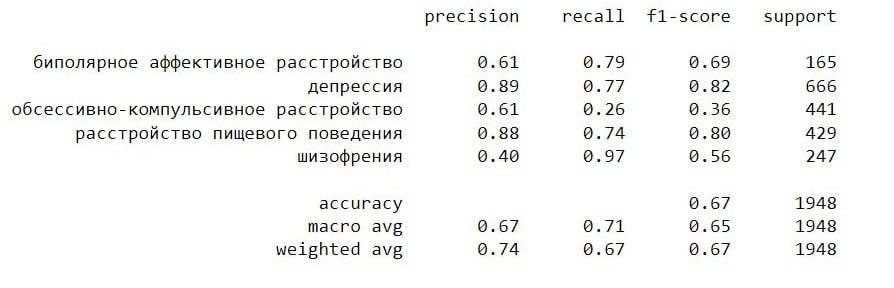

### Ну все, последний вариант архитектуры - деревья на LightGBM

In [81]:
# !pip install lightgbm

In [390]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

lgbm_model = lgb.LGBMClassifier(objective='multiclass', random_state=42, verbose=-1,
                                learning_rate=0.01, reg_alpha=0.2, n_estimators=140, max_depth=16, num_leaves=27)

lgbm_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=16, n_estimators=140,
               num_leaves=27, objective='multiclass', random_state=42,
               reg_alpha=0.2, verbose=-1)

In [391]:
y_pred = lgbm_model.predict(X_test)

In [392]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                                       precision    recall  f1-score   support

  биполярное аффективное расстройство       1.00      0.68      0.81        19
                            депрессия       0.96      0.95      0.96       126
обсессивно-компульсивное расстройство       0.88      0.71      0.79        31
      расстройство пищевого поведения       0.99      0.99      0.99        74
                           шизофрения       0.88      0.97      0.92       117

                             accuracy                           0.93       367
                            macro avg       0.94      0.86      0.89       367
                         weighted avg       0.93      0.93      0.93       367



## По итогу: эта модель (на деревьях LightGBM) выдала лучший результат

Получившиеся метрики:

- accuracy 0.93

- f1-score: по каждому классу >= 0.8

### Как вывод можно сказать следующее:

Лучшие результаты показали модели на XGBoost и LightGBM. Выбор между ними остается сугубо в зависимости от метрик измерения качества, предпочтения автора, дня недели и т.д.

Хочется заметить, что, вероятно, LightGBM сходу дал такой хороший результат (accuracy 0.93 я получил после тюнинга только гиперпараметра learning_rate, все остальные гиперпараметры я подбирал, чтобы получить f1-score по каждому классу >=0.8) по причине того, что он строит несбалансированные деревья, а так как и датасет несбалансирован, то, возможно, это сыграло роль, но это только мое предположение. 

В любом случае,построенные модели дают качество, значительно превосходящее данный бенчмарк, где модель работала в формате zero-shot